# TODO:
        1a) Try stemming to see if accuracy improves
        1b) further cleaning / explanations for tfidf and count (and f1/precision/recall)
        1c) best way to present acc/prec/recall/f1 comparisons???
        1d) n-gram viz thing
        2) which countries most accurate in?
        3) why does RF and NB do better with count?
        4) BERT? maybe?
        6) train unique RNN? ehhhhh
        7) PorterStemmer and TweetTokenizer???

In [215]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import plotly.graph_objects as go

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [216]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1) Load in data

In [217]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [218]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning

In [219]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [220]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [221]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [222]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [223]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [224]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [225]:
# Sanity check
print(make_label('Extremely Negative'))
print(make_label('Extremely Positive'))
print(make_label('Neutral'))

-1
1
0


In [226]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,-1


### 2a) Location Cleaning

In [227]:
# Value counts for general idea of location data
df['Location'].value_counts()

None                     8590
London                    540
United States             528
London, England           520
New York, NY              395
                         ... 
Headquarters in Dubai       1
Yo mama house               1
Vancouver, B.C.             1
Gda?sk, Polska              1
Streetsboro, OH             1
Name: Location, Length: 12221, dtype: int64

In [228]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD')

In [229]:
# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', )
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia')
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth')

In [230]:
# Changing strings found with filters into 3 digit codes
df['newLoc'] = df['Location'].apply(lambda x: 'USA' if x in us_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'IND' if x in india_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'FRA' if x in france_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'None' if x in other_filters else x)

In [231]:
# View results
df['newLoc'].value_counts()[0:20]

None                   8925
USA                    4617
GBR                    1949
IND                     683
CAN                     588
AUS                     584
UK                      232
NGA                     212
ZAF                     178
KEN                     144
FRA                     101
SGP                      87
NZL                      75
IRL                      61
UGA                      58
MYS                      50
PAK                      45
??                       44
North Carolina, USA      41
Portland, OR             40
Name: newLoc, dtype: int64

Further cleaning can obviously be done here, but this has captured most of the 'easy to grab' data. In the interest of my time and sanity, this is fine.

In [232]:
# 0:17 because that's where the labeled countries end
places_df = pd.DataFrame(df['newLoc'].value_counts()[0:17])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'newLoc':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

Plotly visualization of tweets...not all too useful. My guess is that this data was pulled mainly from English speaking countries, as that's where the majority of tweets come from.  Also, considering the data was manually labeled, they probably stuck to only English tweets.

In [233]:
fig = go.Figure(data=go.Choropleth(
    locations = places_df['Country'],
    z = places_df['Tweets'],
    text = places_df['Country'],
    #colorscale = 'Greens',
    autocolorscale=True,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'Number of Tweets',
))
fig.update_layout(
    title_text='Coronavirus Tweets',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

## 3) Wordcloud

In [234]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
mask = np.array(Image.open("rona4.jpeg"))

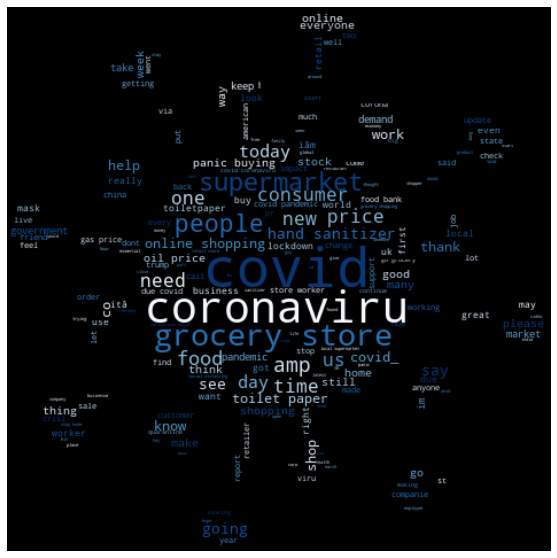

In [235]:
text = df['newTweet'].to_string(index = False)
text = re.sub(r'\n','',text)
wordcloud = WordCloud(colormap = 'Blues', mask = mask).generate(text)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [236]:
# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)
#plt.figure(figsize = (12,12))
#plt.imshow(pos_cloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()

In [237]:
# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)
#plt.figure(figsize = (12,12))
#plt.imshow(neg_cloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()

(-0.5, 473.5, 473.5, -0.5)

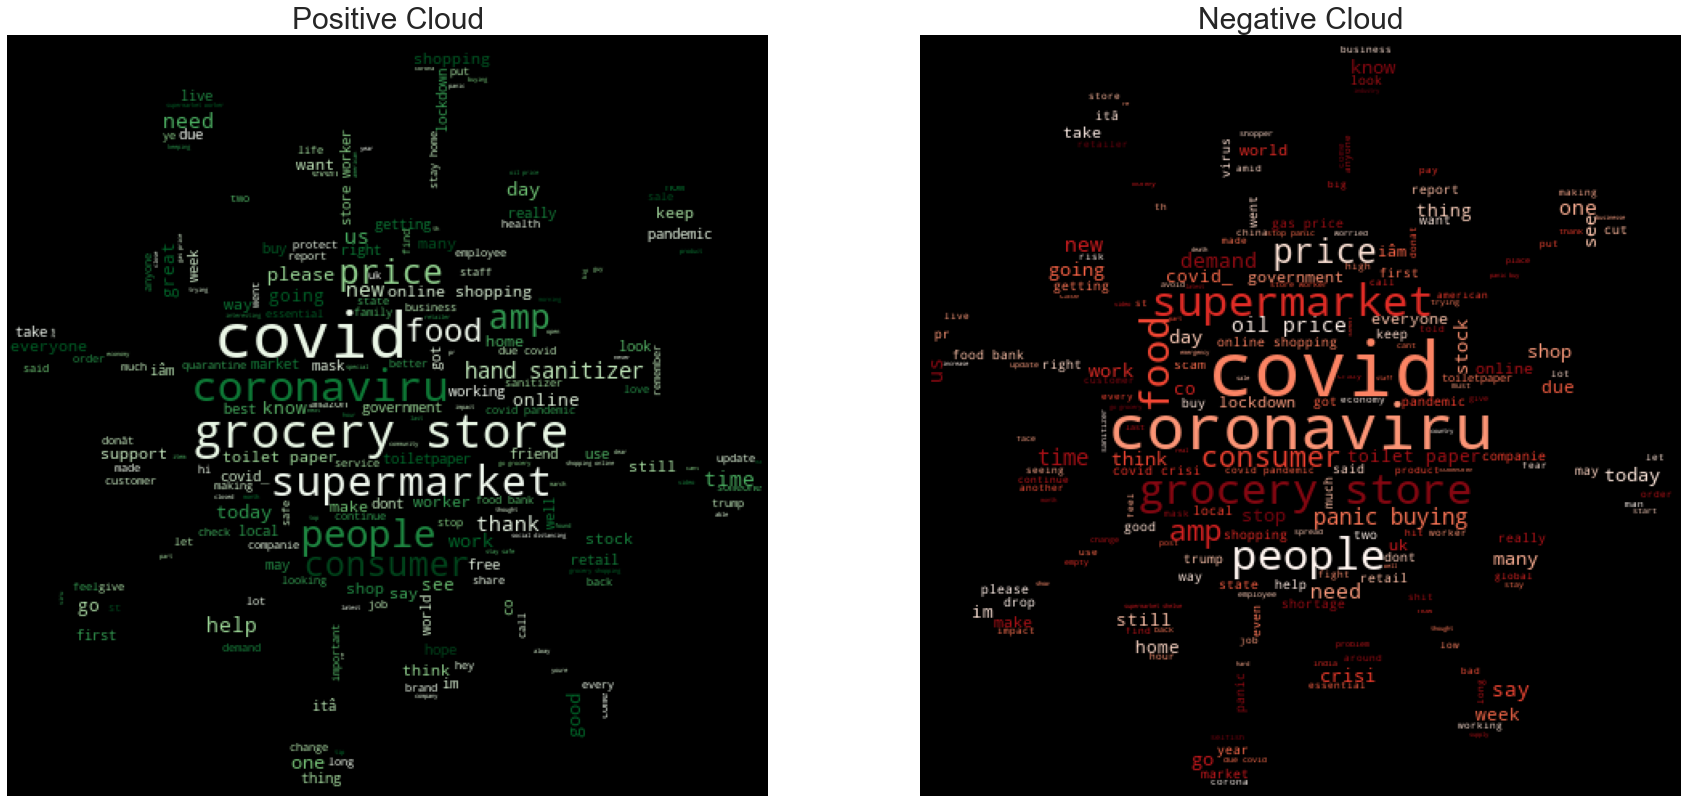

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neg_cloud)
ax2.set_title('Negative Cloud', fontsize = 30)
ax2.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'super market', and 'online shopping' being frequent in both positive and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

## 4) Classification

In [239]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [240]:
# Define dictionary of classification methods.
clf = dict({'SVC': LinearSVC(),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [241]:
# Function that will iterate through models and print 
# classifcation reports and accuracies for each model.
def models(clf, vectorizer, X_train, X_test, y_train, y_test):
    """
    Input:
        clf: dictionary containing classification methods
        vectorizer: ex TfidfVectorizer, CountVectorizer
        X_train: X training data
        X_test: X testing data
        y_train: y training labels
        y_test: y testing label
    
    Output: 
        output_df: a DataFrame containing the accuracy, precision,
        recall, and f1 score of each classification method
    """
    
    accuracy_dict = {}
    clf_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier]),
                    ])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        accuracy_dict[classifier] = accuracy_score(y_test,preds)
        clf_dict[classifier] = classification_report(y_test,preds, output_dict = True)
        precision_dict[classifier] = clf_dict[classifier]['weighted avg']['precision']
        recall_dict[classifier] = clf_dict[classifier]['weighted avg']['recall']
        f1_dict[classifier] = clf_dict[classifier]['weighted avg']['f1-score']
           
        print(classifier)
        print(classification_report(y_test,preds))
        print(classifier + ' Accuracy:', accuracy_score(y_test,preds))
        print('\n')
    
    acc_df = pd.DataFrame.from_dict(accuracy_dict, orient = 'index', columns = ['accuracy'])
    acc_df.reset_index(inplace = True)
    acc_df.columns = ['method', 'accuracy']
    
    precision_df = pd.DataFrame.from_dict(precision_dict, orient = 'index', columns = ['precision'])
    precision_df.reset_index(inplace = True)
    precision_df.columns = ['method', 'precision']
    
    recall_df = pd.DataFrame.from_dict(recall_dict, orient = 'index', columns = ['recall'])
    recall_df.reset_index(inplace = True)
    recall_df.columns = ['method', 'recall']
    
    f1_df = pd.DataFrame.from_dict(f1_dict, orient = 'index', columns = ['f1-score'])
    f1_df.reset_index(inplace = True)
    f1_df.columns = ['method', 'f1-score']
    
    output_df = acc_df.set_index('method').join(precision_df.set_index('method'))
    output_df = output_df.join(recall_df.set_index('method'))
    output_df = output_df.join(f1_df.set_index('method'))
    output_df.reset_index(inplace = True)
    
    return output_df

In [242]:
# Run models function to get output.
tfidf_df = models(clf, TfidfVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.80      0.81      0.81      4607
           0       0.73      0.64      0.68      2308
           1       0.83      0.86      0.84      5433

    accuracy                           0.80     12348
   macro avg       0.78      0.77      0.78     12348
weighted avg       0.80      0.80      0.80     12348

SVC Accuracy: 0.8006154842889537


Logisitc
              precision    recall  f1-score   support

          -1       0.78      0.81      0.79      4607
           0       0.75      0.56      0.64      2308
           1       0.80      0.86      0.83      5433

    accuracy                           0.79     12348
   macro avg       0.78      0.74      0.75     12348
weighted avg       0.78      0.79      0.78     12348

Logisitc Accuracy: 0.7852283770651117


NaiveBayes
              precision    recall  f1-score   support

          -1       0.73      0.63      0.68      4607
           0       0.89      0

### Using TfidfVectorizer, SVC comes out as the best model, very slightly over Logistic Regression. Naive Bayes comes out as the worst model, with an absurdly low recall on neutral tweets, but the best recall on positive tweets. Strange.

In [243]:
count_df = models(clf, CountVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.81      0.79      0.80      4607
           0       0.67      0.70      0.68      2308
           1       0.84      0.83      0.83      5433

    accuracy                           0.79     12348
   macro avg       0.77      0.77      0.77     12348
weighted avg       0.79      0.79      0.79     12348

SVC Accuracy: 0.7921120829284095


Logisitc
              precision    recall  f1-score   support

          -1       0.81      0.80      0.81      4607
           0       0.69      0.72      0.71      2308
           1       0.84      0.84      0.84      5433

    accuracy                           0.80     12348
   macro avg       0.78      0.79      0.79     12348
weighted avg       0.80      0.80      0.80     12348

Logisitc Accuracy: 0.8032879818594104


NaiveBayes
              precision    recall  f1-score   support

          -1       0.68      0.75      0.71      4607
           0       0.72      0

### Logistic Regression barely comes out on top when using the CountVectorizer.  Every model except saw improvement using this method, except for SVC. 

In [244]:
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.803288,0.804388,0.803288,0.803730,count
0,SVC,0.800615,0.798565,0.800615,0.798965,tfidf
0,SVC,0.792112,0.793587,0.792112,0.792729,count
1,Logisitc,0.785228,0.783079,0.785228,0.781033,tfidf
3,RandomForest,0.757127,0.757876,0.757127,0.756972,count
3,RandomForest,0.735828,0.734909,0.735828,0.734657,tfidf
2,NaiveBayes,0.679138,0.684157,0.679138,0.654361,count
2,NaiveBayes,0.638646,0.700328,0.638646,0.576321,tfidf


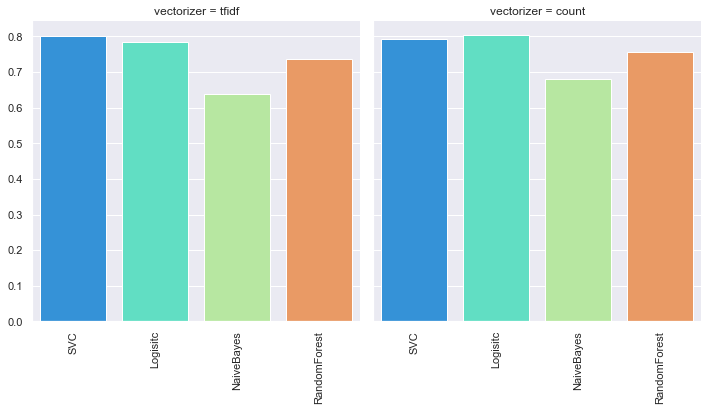

In [245]:
g = sns.FacetGrid(combined_df, col = 'vectorizer', height = 5)
g.map_dataframe(sns.barplot, x = 'method', y = 'accuracy', palette = 'rainbow')
g.set_xticklabels(rotation = 90)

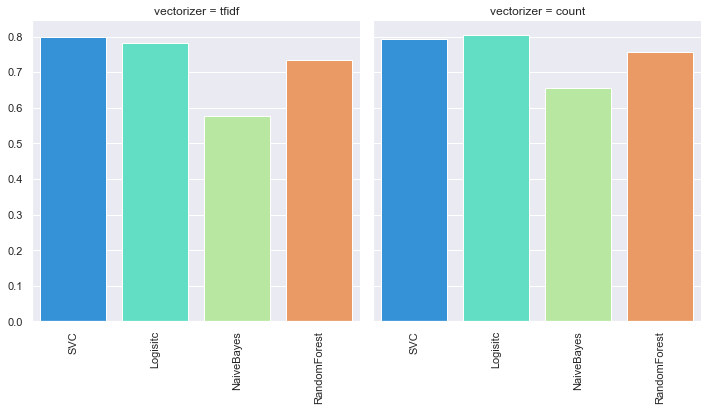

In [246]:
g = sns.FacetGrid(combined_df, col = 'vectorizer', height = 5)
g.map_dataframe(sns.barplot, x = 'method', y = 'f1-score', palette = 'rainbow')
g.set_xticklabels(rotation = 90)

These barplots don't really help explain anything... come up with better viz or way to present results